# Predicting Hazardous Asteroids
Potentially Hazardous Asteroids, also reffered to as PHAs, are currently defined based on parameters that measure the asteroid's potentially threatening, close approaches to the Earth. In this notebook, we predict whether an asteroid ought to be categorised as such.  

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# models
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from yellowbrick.features import ParallelCoordinates

import shap
shap.initjs()

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
plt.style.use('default')
sns.set_style('whitegrid')

In [4]:
filepath = "C://Users//Angel//Hazardous_Asteroid_Prediction//input"
df = pd.read_csv(filepath+'//dataset.csv')
df.head(5)

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.4000,939.4000,0.0900,0.2000,JPL 47,2458600.5000,58600,20190427.0000,J2000,0.0760,2.7692,2.5587,10.5941,80.3055,73.5977,77.3721,2.9796,0.2139,2458238.7541,20180430.2541,1683.1457,4.6082,1.5948,620.6405,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,MBA,0.4330
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.2000,545.0000,0.1010,18.0000,JPL 37,2459000.5000,59000,20200531.0000,J2000,0.2300,2.7738,2.1359,34.8329,173.0247,310.2024,144.9757,3.4117,0.2133,2458320.9624,20180721.4624,1687.4110,4.6199,1.2343,480.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,MBA,0.3594
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.3300,246.5960,0.2140,10.5940,JPL 112,2459000.5000,59000,20200531.0000,J2000,0.2569,2.6683,1.9827,12.9910,169.8515,248.0662,125.4354,3.3539,0.2261,2458445.7922,20181123.2922,1592.0138,4.3587,1.0343,402.5146,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,MBA,0.3385
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.0000,525.4000,0.4228,0.2000,JPL 35,2458600.5000,58600,20190427.0000,J2000,0.0887,2.3614,2.1519,7.1418,103.8108,150.7285,95.8619,2.5709,0.2716,2458247.5596,20180509.0596,1325.4328,3.6288,1.1395,443.4514,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,MBA,0.3998
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.9000,106.6990,0.2740,3.1400,JPL 114,2459000.5000,59000,20200531.0000,J2000,0.1909,2.5740,2.0826,5.3674,141.5710,358.6484,17.8463,3.0655,0.2387,2458925.7231,20200317.2231,1508.4144,4.1298,1.0958,426.4330,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,MBA,0.5219


In [5]:
df.shape

(958524, 45)

In [6]:
#X_train.columns

In [7]:
df.columns

Index(['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H',
       'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch',
       'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'rms'],
      dtype='object')

In [8]:
df.describe()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,958524.0000,952261.0000,136209.0000,135103.0000,136081.0000,958524.0000,958524.0000,958524.0000,958524.0000,958524.0000,958524.0000,958524.0000,958524.0000,958524.0000,958523.0000,958520.0000,958524.0000,958524.0000,958524.0000,958520.0000,958523.0000,938603.0000,958397.0000,938602.0000,938602.0000,938602.0000,938602.0000,938602.0000,938602.0000,938602.0000,938598.0000,938602.0000,938602.0000,938598.0000,958522.0000
mean,3810113.9886,16.9064,5.5064,0.1306,0.4792,2458869.2820,58868.7820,20196925.0516,0.1561,2.9021,2.3949,9.0549,168.4564,181.3695,177.3526,3.4558,0.2367,2458856.2367,20195807.5415,5085.3442,13.9229,1.4152,539.3642,0.7263,15.4142,19.8293,1.1684,5.3102,1370061.6389,1369977.2267,21.3145,0.0506,431278021.0009,85258.1498,0.5612
std,6831540.8805,1.7904,9.4252,0.1103,0.7829,701.6716,701.6716,19303.5368,0.0926,39.7195,2.1392,6.6377,102.8817,103.8880,105.8168,71.7694,0.0794,1580.5062,43376.6856,2308961.0057,6321.5808,2.1567,834.3070,93.3639,4392.3807,2903.7853,128.2231,1333.3812,915899566.2384,915899068.4014,7197.0340,9.8150,295304579371.8069,27676810.5905,2.7457
min,2000001.0000,-1.1000,0.0025,0.0010,0.0005,2425051.5000,25051.0000,19270620.0000,0.0000,-14702.4479,0.0705,0.0077,0.0000,0.0001,-70.7037,0.6538,0.0000,2283183.4055,15390106.9055,151.1918,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2239631.7500,16.1000,2.7800,0.0530,0.1800,2459000.5000,59000.0000,20200531.0000,0.0922,2.3878,1.9714,4.1654,80.6044,91.4821,83.7850,2.7816,0.1895,2458560.3223,20190317.8223,1347.7380,3.6899,0.9797,375.3949,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.5180
50%,2479262.5000,16.9000,3.9720,0.0790,0.3320,2459000.5000,59000.0000,20200531.0000,0.1450,2.6470,2.2258,7.4157,159.8269,182.3581,175.6411,3.0470,0.2289,2458944.5914,20200405.0914,1572.9756,4.3066,1.2409,477.7062,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0002,0.0000,0.5663
75%,3752517.7500,17.7140,5.7650,0.1900,0.6200,2459000.5000,59000.0000,20200531.0000,0.2007,3.0019,2.5783,12.4076,252.2478,271.5216,269.8657,3.3648,0.2671,2459361.2851,20210526.7851,1899.7650,5.2013,1.5934,617.3248,0.0000,0.0000,0.0000,0.0000,0.0002,0.0003,0.0002,0.0000,0.0000,0.0008,0.0001,0.6139
max,54017232.0000,33.2000,939.4000,1.0000,140.0000,2459000.5000,59000.0000,20200531.0000,1.8554,33488.8960,80.3988,175.0829,359.9998,359.9996,491.6180,66972.7961,2.3811,2546362.2932,22590808.7932,2238461721.1518,6128574.1852,79.4766,30929.9084,39425.0000,3241200.0000,1015000.0000,55330.0000,1199100.0000,884510000000.0000,884510000000.0000,5509700.0000,7698.8000,285310000000000.0000,19107000000.0000,2686.6000


In [9]:
# Potentially hazardous asteroids
df['pha'].value_counts()

N    936537
Y      2066
Name: pha, dtype: int64

In [10]:
# Near Earth Object
df['neo'].value_counts()

N    935625
Y     22895
Name: neo, dtype: int64

In [11]:
# function for performing a summarising, preliminary EDA
def initial_eda(df):
    """ Prints the dataFrames's column names, data types, 
    number of distinct values, number of missing values
    @param df: pandas DataFrame
    """
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%65s %20s   %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%65s %20s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

In [12]:
# performe EDA  
#initial_eda(df)

In [13]:
to_drop = ['id', 'spkid', 'full_name', 'moid', 'moid_ld', 'H', 'class', 
           'pdes', 'name', 'prefix', 'orbit_id',
           'equinox', 'diameter', 'albedo', 'diameter_sigma']
df.drop(to_drop, axis=1, inplace=True)

In [14]:
df.dropna(inplace = True)

In [15]:
#initial_eda(df)

In [16]:
# Potentially hazardous asteroids
df['pha'].value_counts()

N    936531
Y      2066
Name: pha, dtype: int64

In [17]:
df['pha'] = df['pha'].map({'Y': 1, 'N': 0})
df['neo'] = df['neo'].map({'Y': 1, 'N': 0})

In [18]:
#df = pd.get_dummies(df, columns=['class'])

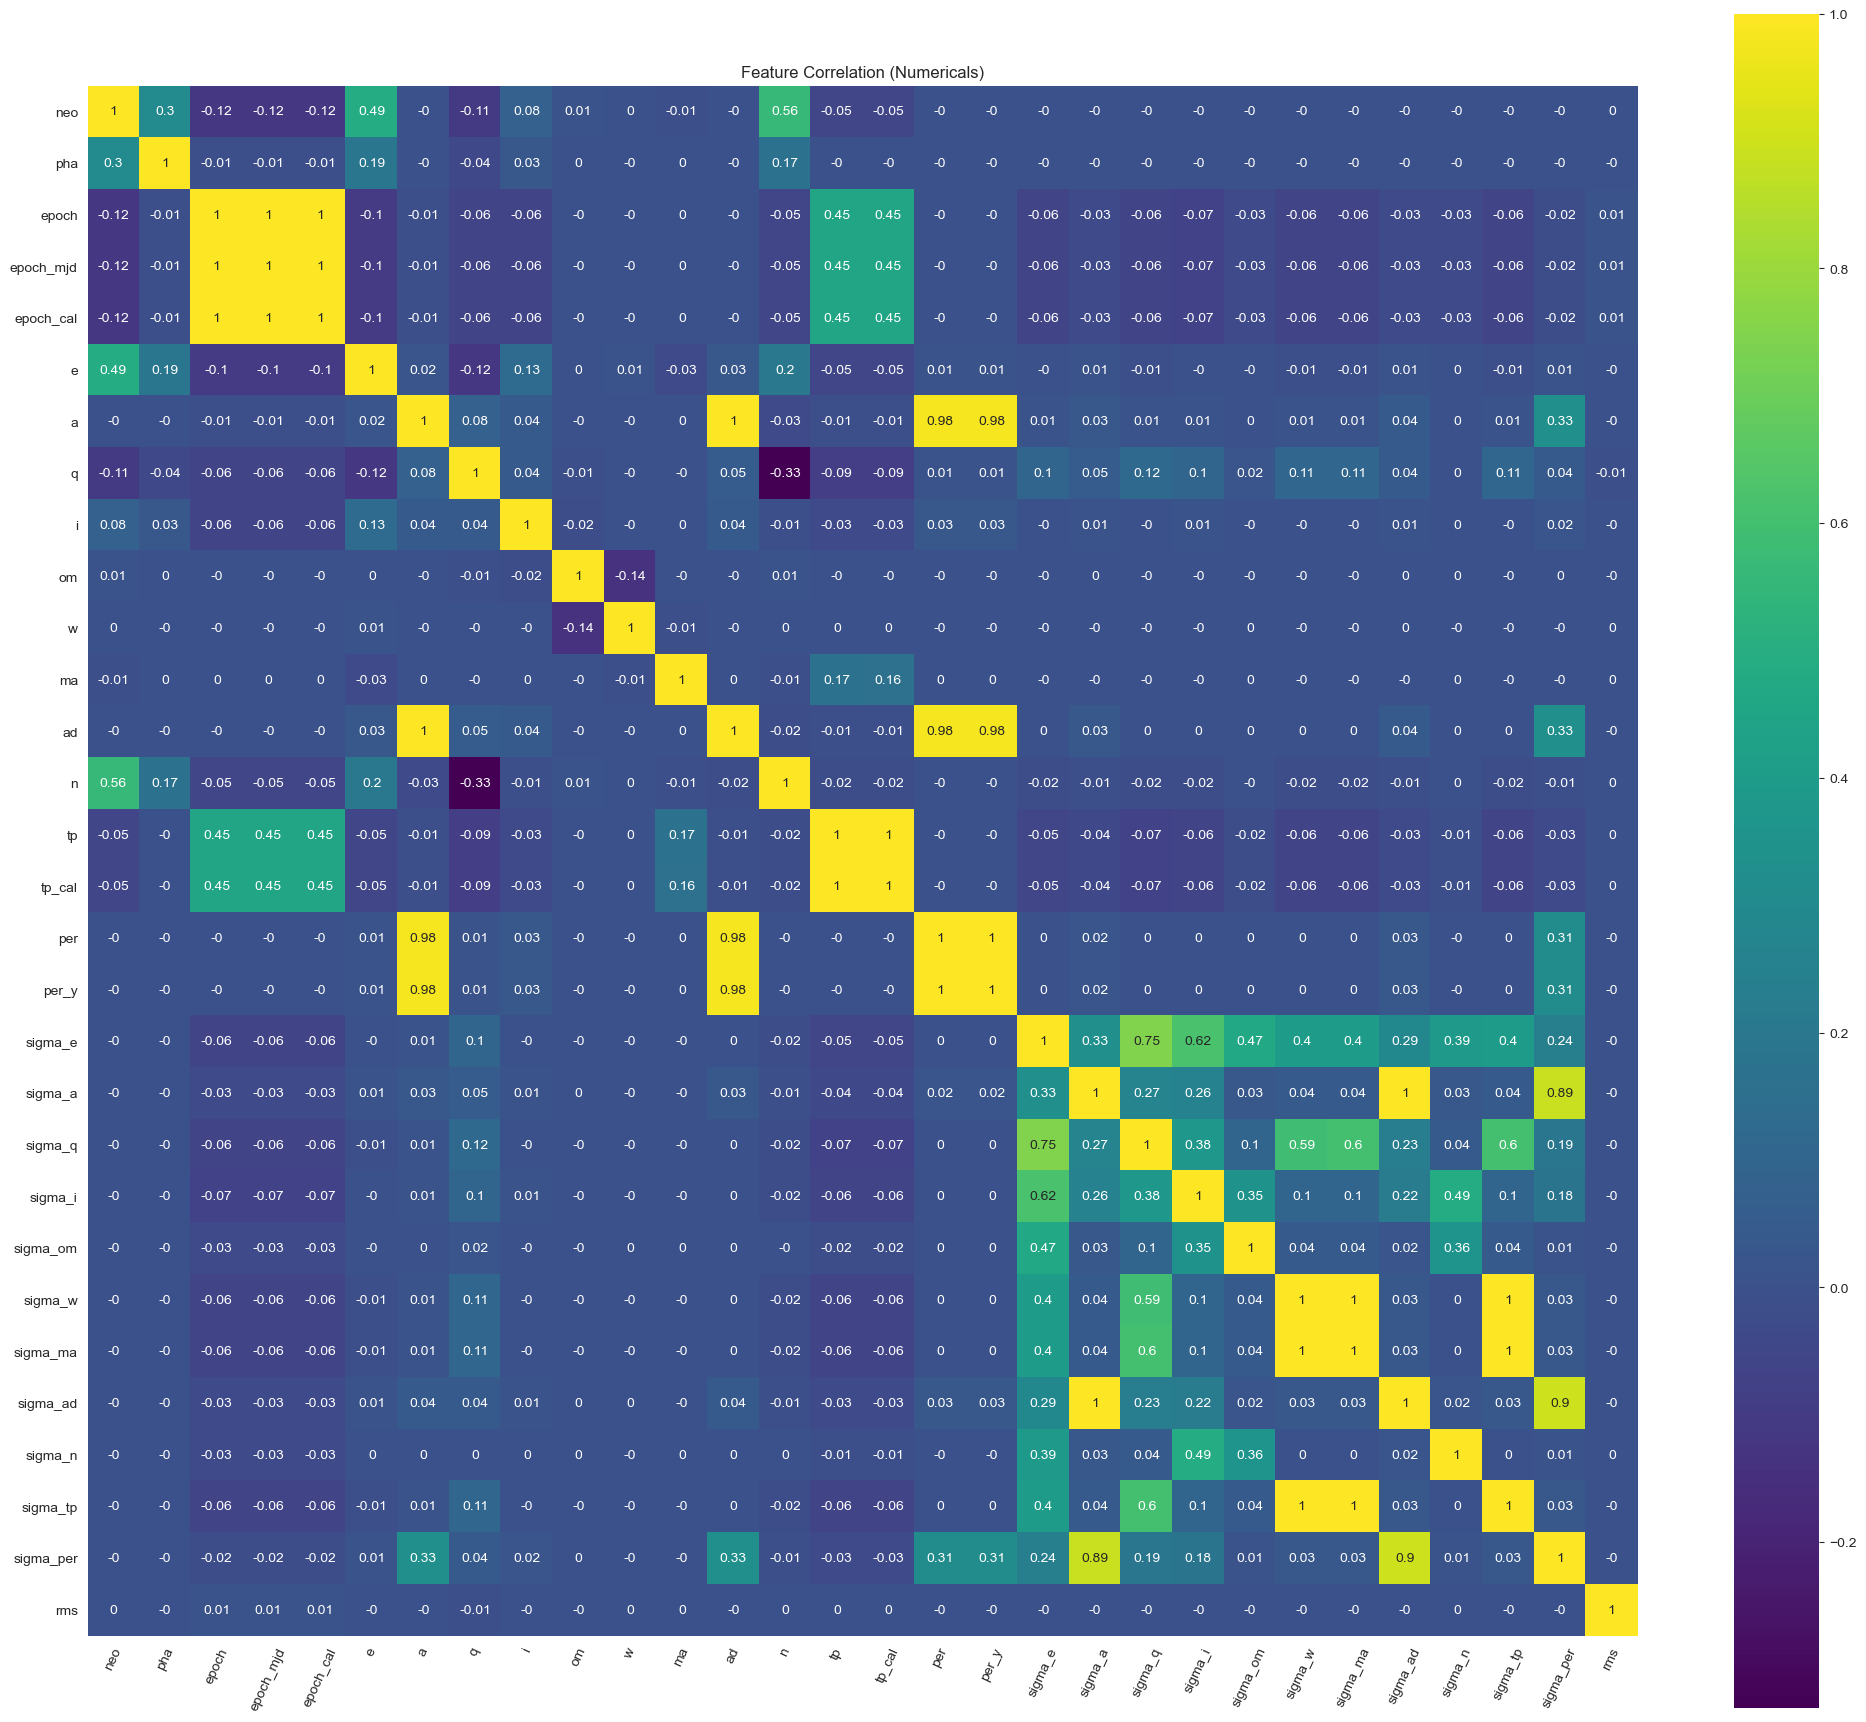

In [19]:
# plot the heatmap of numerical feature correlation
corr = df.corr() 
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 22))
    ax = sns.heatmap(round(corr,2), 
                     xticklabels=corr.columns, 
                     yticklabels=corr.columns,
                     square=True, 
                     annot=True, 
                     cmap='viridis')
plt.xticks(rotation=65);
plt.title('Feature Correlation (Numericals)');

In [20]:
#sns.countplot(x=df['pha'])

In [21]:
df.pha.value_counts()

0    936531
1      2066
Name: pha, dtype: int64

In [22]:
#sns.countplot(x=df['neo'])

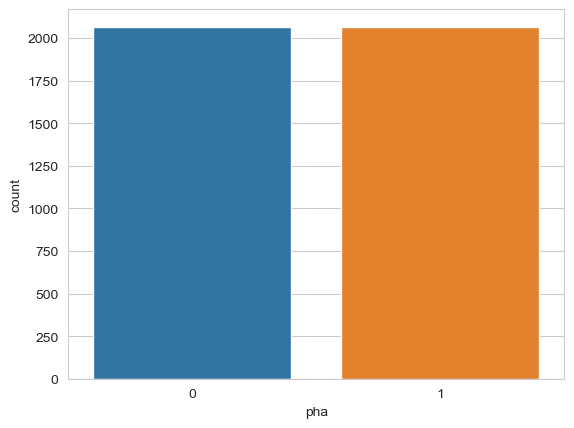

In [23]:
#balancing
df_bal = (df.groupby('pha', as_index=False)
        .apply(lambda x: x.sample(n=2066))
        .reset_index(drop=True))
sns.countplot(x=df_bal['pha'])

In [24]:
df_bal

,neo,pha,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
0,0,0,2459000.5000,59000,20200531.0000,0.0839,2.6476,2.4255,15.2568,77.6070,212.7180,156.1367,2.8698,0.2288,2458318.0270,20180718.5270,1573.5589,4.3082,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.5655
1,0,0,2459000.5000,59000,20200531.0000,0.1986,2.5963,2.0807,3.8427,29.7768,39.7513,30.0738,3.1120,0.2356,2458872.8504,20200124.3504,1528.0379,4.1835,0.0000,0.0000,0.0000,0.0000,0.0002,0.0006,0.0002,0.0000,0.0000,0.0010,0.0017,0.5846
2,0,0,2459000.5000,59000,20200531.0000,0.2565,2.9040,2.1593,8.0685,41.7159,134.9457,209.6017,3.6488,0.1992,2459755.6677,20220625.1677,1807.6027,4.9489,0.0000,0.0000,0.0000,0.0000,0.0002,0.0003,0.0002,0.0000,0.0000,0.0008,0.0000,0.5260
3,0,0,2459000.5000,59000,20200531.0000,0.1524,2.6016,2.2050,7.7235,180.3779,42.7422,57.4544,2.9982,0.2349,2458755.8905,20190929.3905,1532.6847,4.1963,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.6279
4,0,0,2459000.5000,59000,20200531.0000,0.2297,3.1570,2.4318,15.3755,0.9441,72.6490,356.3623,3.8823,0.1757,2459021.2037,20200620.7037,2048.8953,5.6096,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0002,0.0000,0.0000,0.0009,0.0001,0.6081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,1,1,2457044.5000,57044,20150122.0000,0.8517,3.5973,0.5336,6.1115,215.7410,279.8826,353.8442,6.6611,0.1445,2457087.1138,20150305.6138,2492.1136,6.8230,0.1141,2.8612,0.0206,0.3578,2.2549,5.4062,7.7130,5.2979,0.1723,2.5710,2973.2000,0.2448
4128,1,1,2459000.5000,59000,20200531.0000,0.7898,2.2811,0.4794,9.4446,301.8564,271.6061,158.7076,4.0827,0.2861,2458445.7456,20181123.2456,1258.3618,3.4452,0.0000,0.0002,0.0000,0.0004,0.0003,0.0005,0.0804,0.0004,0.0000,0.1955,0.1943,0.3392
4129,1,1,2459000.5000,59000,20200531.0000,0.3741,0.7206,0.4510,11.9463,283.2320,5.6947,134.6519,0.9902,1.6112,2458916.9289,20200308.4289,223.4324,0.6117,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3909
4130,1,1,2459000.5000,59000,20200531.0000,0.6070,1.7338,0.6813,0.9206,317.3571,228.7465,337.6679,2.7863,0.4317,2459052.2278,20200721.7278,833.8682,2.2830,0.0000,0.0000,0.0000,0.0000,0.0005,0.0005,0.0000,0.0000,0.0000,0.0001,0.0000,0.4295


In [25]:
X = df_bal.drop('pha', axis=1)
y = df_bal['pha']

In [26]:
sc = MinMaxScaler((-1, 1))
# saving column names
scaled_columns = X.columns
X_scaled = pd.DataFrame(sc.fit_transform(X))
# re-naming column names of X_train back to original
X_scaled.columns = scaled_columns

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [28]:
# initialising a Dataframe for model evaluation & comparison.
models = pd.DataFrame(columns = ['Method', 'Accuracy', 
                                 'F1 Score 0', 'F1 Score 1',
                                 'Precision 0', 'Precision 1', 
                                 'Recall 0', 'Recall 1'])

In [29]:
# print prediction metrics and insert model results into dataFrame for comparison
def prediction_metrics(y_pred, method):
    print(classification_report(y_test.astype(int), 
                                y_pred, 
                                zero_division = 0))
    print(confusion_matrix(y_test, 
                           y_pred))
    report = classification_report(y_test.astype(int),
                                   y_pred, 
                                   zero_division = 0, 
                                   output_dict=True)
    metrics = [method, report['accuracy']]
    for metric in ['precision', 'recall', 'f1-score']:
        metrics.append(report['0'][metric])
        metrics.append(report['1'][metric])
    models.loc[len(models)] = metrics

## 1. XGBClassifier

In [30]:
xgb = XGBClassifier(use_label_encoder=False, 
                    eval_metric = 'logloss', 
                    n_estimators = 100, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train.ravel())
y_pred = xgb.predict(X_test).astype(int)
report = prediction_metrics(y_pred, 'XGB Classifier')

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       534
           1       0.99      1.00      1.00       499

    accuracy                           1.00      1033
   macro avg       1.00      1.00      1.00      1033
weighted avg       1.00      1.00      1.00      1033

[[530   4]
 [  0 499]]


## 2. Random Forest Classifier

In [31]:
ranfor = RandomForestClassifier(n_jobs = -1, 
                                n_estimators = 200, 
                                criterion = 'gini')
ranfor.fit(X_train, y_train.ravel())
y_pred = ranfor.predict(X_test).astype(int)
report = prediction_metrics(y_pred, 'Random Forest Classifier')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       534
           1       0.98      1.00      0.99       499

    accuracy                           0.99      1033
   macro avg       0.99      0.99      0.99      1033
weighted avg       0.99      0.99      0.99      1033

[[525   9]
 [  0 499]]


## 3. SVC (Support Vector Classifier)

In [32]:
svc = SVC(probability=False,
         C = 3,
         gamma = 0.1)
svc.fit(X_train, y_train.ravel())
y_pred = svc.predict(X_test).astype(int)
report = prediction_metrics(y_pred, 'Support Vector Classifier')

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       534
           1       0.97      1.00      0.99       499

    accuracy                           0.99      1033
   macro avg       0.99      0.99      0.99      1033
weighted avg       0.99      0.99      0.99      1033

[[520  14]
 [  0 499]]


## 4. kNN Classifier

In [33]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test).astype(int)
report = prediction_metrics(y_pred, 'KNN Classifier')

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       534
           1       0.97      1.00      0.99       499

    accuracy                           0.99      1033
   macro avg       0.99      0.99      0.99      1033
weighted avg       0.99      0.99      0.99      1033

[[520  14]
 [  0 499]]


In [34]:
models

,Method,Accuracy,F1 Score 0,F1 Score 1,Precision 0,Precision 1,Recall 0,Recall 1
0,XGB Classifier,0.9961,1.0000,0.9920,0.9925,1.0000,0.9962,0.9960
1,Random Forest Classifier,0.9913,1.0000,0.9823,0.9831,1.0000,0.9915,0.9911
2,Support Vector Classifier,0.9864,1.0000,0.9727,0.9738,1.0000,0.9867,0.9862
3,KNN Classifier,0.9864,1.0000,0.9727,0.9738,1.0000,0.9867,0.9862


## Why so great? 

Apparently, by definition, 


Potentially Hazardous Asteroids (PHAs) are currently defined based on parameters that measure the asteroid's potential to make threatening close approaches to the Earth. Specifically, all asteroids with an Earth Minimum Orbit Intersection Distance (MOID) of 0.05 au or less and an absolute magnitude (H) of 22.0 or less are considered PHAs. In other words, asteroids that can't get any closer to the Earth (i.e., MOID) than 0.05 au (roughly 7,480,000 km or 4,650,000 mi) or are smaller than about 140 m (~500 ft) in diameter (i.e., H = 22.0 with assumed albedo of 14%) are not considered PHAs. 

https://cneos.jpl.nasa.gov/about/neo_groups.html

## XGBoost Feature Importance

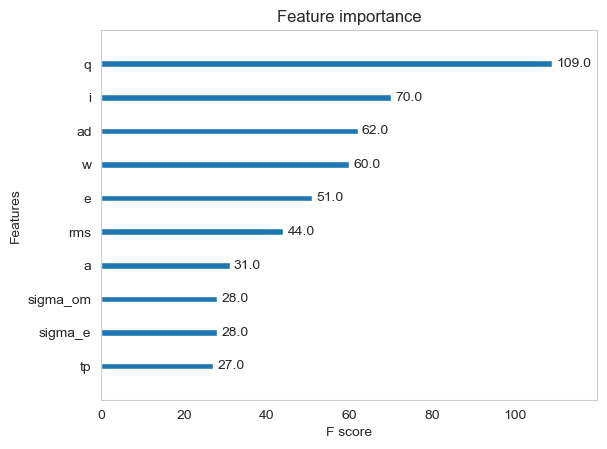

In [35]:
ax = plot_importance(xgb, max_num_features=10)
fig = ax.figure
ax.grid(False)
fig.savefig('xgboost.png', figsize=(10, 8), dpi=500)

## Shap values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


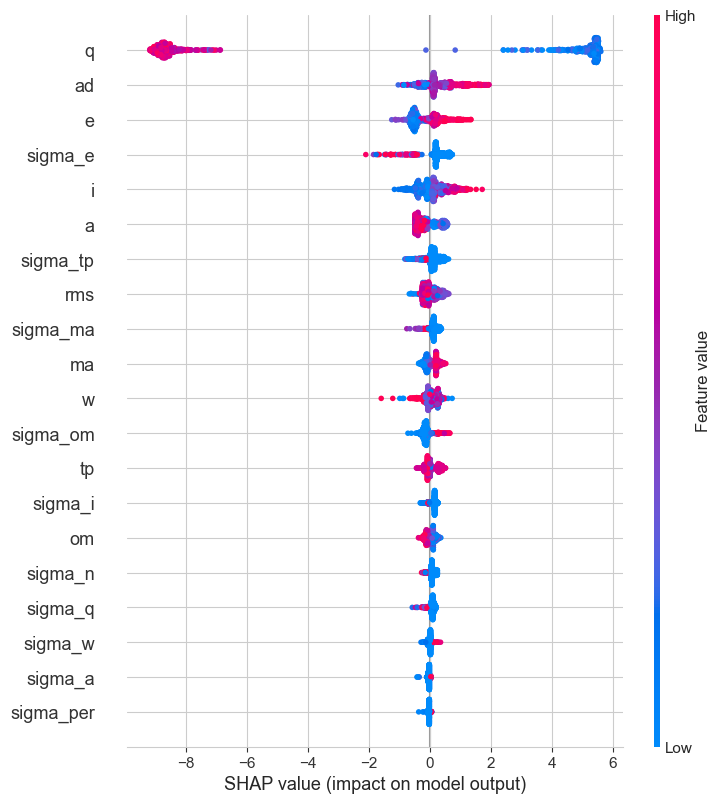

In [36]:
explainer = shap.TreeExplainer(xgb)
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test)


In [37]:
def make_shap_waterfall_plot(shap_values, features, num_display):
    """ Plot a waterfall with ranked features based on shap feature importance
    @param shap_values: computed Shap values
    @param features: pandas DataFrame
    @param num_display: number of features to display on plot
    @return flat: flattened predictions of best model
    """
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    

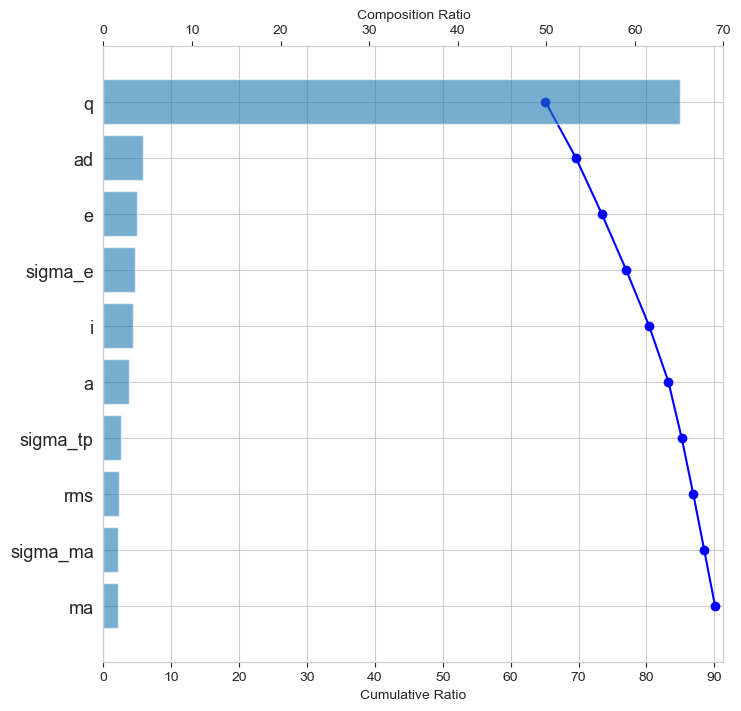

In [38]:
make_shap_waterfall_plot(shap_values, X_train, 10)

In [39]:
# clustering shap values
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [40]:
# Instantiate the visualizer
features = ['moid', 'H', 'q', 'e', 'sigma_om']
classes = [ '0','1']

visualizer = ParallelCoordinates(classes=classes, 
                                 features=features,
                                 sample=0.1, 
                                 size = (1000,500)
                                )
visualizer.fit(X_train[features], y_train)   
visualizer.transform(X_train[features])  
visualizer.poof()

KeyError: "['moid', 'H'] not in index"

<Figure size 1000x500 with 0 Axes>

In [ ]:
df_corr = df_bal.corr()
df_corr = df_corr.pha
df_corr = round(df_corr.sort_values(ascending=False), 2)

In [ ]:
# create a heatmap plot with one constant column "Outcome"
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 8))
    ax = sns.heatmap(df_corr.values.reshape(len(df_corr.keys()),1), 
                     yticklabels=df_corr.keys(),
                     xticklabels=['pha'], 
                     annot=True, 
                     cmap='plasma')
    
plt.title("Feature Correlation with Target Value")

In [ ]:
def rfc_Cl(method, num_of_feats):
    """ Train and test Random Forest Classifier
    @param method: number of selection method used
    @param num_of_feats: number of features of selection method used
    @return ranfor: Random Forest Classifier used
    """
    ranfor = RandomForestClassifier(n_jobs = -1)
    parameters_ranfor = {'n_estimators':[100,200], 
                         'criterion':['gini','entropy']}    
    best = optimizing(ranfor, parameters_ranfor)
    y_pred = best.predict(X_test).astype(int)
    report = prediction_metrics(y_pred, 'Random Forest Classifier')

In [ ]:
def optimizing(clf, params):
    print('gridsearch')
    gs_clf = GridSearchCV(clf, params)
    print('fitting gridsearch')
    gs_clf.fit(X_train, y_train.ravel())
    print('getting best')
    best = gs_clf.best_estimator_
    print(best)
    return best